In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# predefine the boxplot for plotting important features in the taxi dataset
def boxplot(df):
    cols = ['minutes', 'trip_distance', 'fare_amount', 'tip_amount']
    fig, axs = plt.subplots(1, 4, figsize=(15,5))
    for i in range(4):
        axs[i].boxplot(df[cols[i]])
        axs[i].set_xlabel(cols[i])
    plt.show()

In [3]:
# preprocessing for 2016 December as a demonstration
## read data
data_path = '../data/curated/2016_12_sc.parquet'
df = pd.read_parquet(data_path)
## define the time range for the month that is going to be cleaned
date1 = f"2016-12-01 00:00:00"
date2 = f"2016-12-30 23:59:59"

## remove any data points that are outside the predefined month time range 
df = df[(df["tpep_pickup_datetime"] >= date1) & (df["tpep_pickup_datetime"] <= date2)]

## remove data points that has negative trip distance, which are not reasonable
df = df[df.trip_distance > 0]

## only keep records with credit card and cash payment since other payments only play a very limited role in the data
df = df[(df['payment_type'] == 1) | (df['payment_type'] == 2)]

## remove all data that does not follow normal payment trend (i.e. lower than basic fare amount or negative tip amount)
removed_df = df[(df.fare_amount >= 2.5) & (df.tip_amount >= 0)]
removed_df['minutes'] = (removed_df.tpep_dropoff_datetime - removed_df.tpep_pickup_datetime).to_numpy().astype('timedelta64[s]').astype(int)/60
removed_df = removed_df[removed_df['minutes'] >=0]

## remove records that are higher than the legal speed limit
removed_df1 = removed_df[(removed_df.trip_distance/(removed_df.minutes/60))<70]

## Cleaning possible human errors by looking at the boxplot
removed_df2 = removed_df1[(removed_df1.trip_distance < 200) & (removed_df1.fare_amount < 500) & (removed_df1.tip_amount < 200)]

## Removing income rate outliers by 1.5IQR lower fence and 0.5IQR upper fence
cols = ['minutes', 'trip_distance', 'fare_amount', 'tip_amount']
Q0 = removed_df2[cols].quantile(0.05)
Q1 = removed_df2[cols].quantile(0.25)
Q3 = removed_df2[cols].quantile(0.75)
Q4 = removed_df2[cols].quantile(0.95)
IQR = Q3 - Q1
removed_df3 = removed_df2[((removed_df2[cols] >= (Q1 - 1.5 * IQR)) & (removed_df2[cols] <= (Q3 + 0.5 * IQR))).all(axis=1)]

## Filling tips amounts for credit cash payment
### calculate average percentage of tip amount for credit card payments
card_pmt = removed_df3.loc[removed_df3['payment_type'] == 1, ['tip_amount','total_amount']]
tip_rate = (card_pmt.tip_amount/card_pmt.total_amount).mean()
### fill the tip for cash payments by applying the tip amount rate
removed_df3.loc[removed_df3['payment_type'] == 2, 'tip_amount'] = (removed_df3['total_amount']-2.5) * tip_rate
removed_df3['cashtip'] = removed_df3['tip_amount'] * (removed_df3['payment_type']-1)
### calculate the total amount the taxi driver will receive for each trip by adding tips and fare amount
removed_df3['total_adjusted_amount'] = removed_df3['cashtip']+ removed_df3['total_amount']
removed_df3 = removed_df3.drop(['cashtip'], axis=1)

## Calculate income rate
removed_df3['income_rate'] = (removed_df3['total_adjusted_amount']-2.5) / removed_df3['minutes']

## Intuitively choose features that are relative to the study
after_prep_df = removed_df3[['PULocationID','DOLocationID','tpep_pickup_datetime','tpep_dropoff_datetime','total_adjusted_amount','trip_distance','fare_amount','tip_amount','income_rate']]

## Aggregate the dataframe by PULocationID and then date
date = after_prep_df['tpep_pickup_datetime'].dt.date
after_prep_df["date"] = date        
agg_df = after_prep_df.groupby(['PULocationID','date']).agg({'PULocationID':'first','income_rate':'mean','total_adjusted_amount':'mean','trip_distance':'mean','fare_amount':'mean','tip_amount':'median'})
agg_df = agg_df.drop(['PULocationID'], axis=1)
agg_df = agg_df.reset_index()

## store the preprocessed data into a CSV file
agg_df.to_csv('../data/curated/'+'cleaned_data_new.csv', index = False)


/opt/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/opt/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


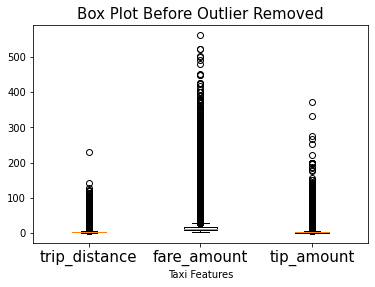

In [14]:
cols = ['trip_distance','fare_amount','tip_amount']
fig, ax = plt.subplots()
ax.boxplot(removed_df1[cols])
ax.set_xticklabels(cols, fontsize=15)
plt.title('Box Plot Before Outlier Removed',fontsize=15)
plt.xlabel('Taxi Features')
plt.show()
fig.savefig('../plots/1.Boxplot of 2016.12 taxi features Before Outlier Removing.png')

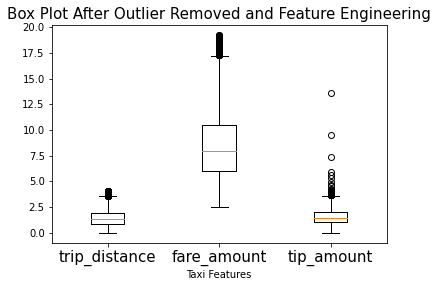

In [16]:
cols = ['trip_distance','fare_amount','tip_amount']
fig, ax = plt.subplots()
ax.boxplot(removed_df3[cols])
ax.set_xticklabels(cols, fontsize=15)
plt.title('Box Plot After Outlier Removed and Feature Engineering',fontsize=15)
plt.xlabel('Taxi Features')
plt.show() 
fig.savefig('../plots/2.Boxplot of 2016.12 taxi features After Outlier Removing.png')

In [ ]:
removed_df1[removed_df1['trip_distance']>150]
# <200miles trip distance is relatively reasonable

In [ ]:
removed_df1[removed_df1['fare_amount']>500]
# <500 dollars of fare amount is relatively reasonable

In [ ]:
removed_df1[removed_df1['tip_amount']>180]
# <200 dollars tip amounts is relatively reasonable

In [7]:
import calendar
import datetime

# define a for loop to automatically generate preprocessed data in 2017 and 2018
for year in range(2017, 2018+1):
    # define the months needed in 2017 and 2018
    for month in [1, 2, 11, 12]:
        ## read data
        data_path = '../data/curated/' + str(year) + '_' + str(month) + '_sc.parquet'
        df = pd.read_parquet(data_path)
        
        ## define the time range for the month that is going to be cleaned
        date1 = datetime.datetime(year=year, month=month, day=1)
        date2 = datetime.datetime(year=year, month=month, day=calendar.monthrange(year, month)[1],hour = 23, minute = 59, second = 59)
        
        ## remove any data points that are outside the predefined month time range 
        df = df[(df["tpep_pickup_datetime"] >= date1) & (df["tpep_pickup_datetime"] <= date2)]
        
        ## remove data points that has negative trip distance, which are not reasonable
        df = df[df.trip_distance > 0]
        
        ## only keep records with credit card and cash payment since other payments only play a very limited role in the data
        df = df[(df['payment_type'] == 1) | (df['payment_type'] == 2)]
        
        ## remove all data that does not follow normal payment trend (i.e. lower than basic fare amount or negative tip amount)
        removed_df = df[(df.fare_amount >= 2.5) & (df.tip_amount >= 0)]
        removed_df['minutes'] = (removed_df.tpep_dropoff_datetime - removed_df.tpep_pickup_datetime).to_numpy().astype('timedelta64[s]').astype(int)/60
        removed_df = removed_df[removed_df['minutes'] >=0]
        
        ## remove records that are higher than the legal speed limit
        removed_df1 = removed_df[(removed_df.trip_distance/(removed_df.minutes/60))<70]
        
        ## Cleaning possible human errors by following extreme values rule in 2016 December 
        removed_df2 = removed_df1[(removed_df1.trip_distance < 200) & (removed_df1.fare_amount < 500) & (removed_df1.tip_amount < 200)]
        
        ## Removing income rate outliers by 1.5IQR
        cols = ['minutes', 'trip_distance', 'fare_amount', 'tip_amount']
        Q0 = removed_df2[cols].quantile(0.05)
        Q1 = removed_df2[cols].quantile(0.25)
        Q3 = removed_df2[cols].quantile(0.75)
        Q4 = removed_df2[cols].quantile(0.95)
        IQR = Q3 - Q1
        removed_df3 = removed_df2[((removed_df2[cols] >= (Q1 - 1.5 * IQR)) & (removed_df2[cols] <= (Q3 + 0.5 * IQR))).all(axis=1)]
        
        ## Filling tips amounts for credit cash payment
        ### calculate average percentage of tip amount 
        card_pmt = removed_df3.loc[removed_df3['payment_type'] == 1, ['tip_amount','total_amount']]
        tip_rate = (card_pmt.tip_amount/card_pmt.total_amount).mean()
        ### fill the tip for cash payments by applying the tip amount rate
        removed_df3.loc[removed_df3['payment_type'] == 2, 'tip_amount'] = (removed_df3['total_amount']-2.5) * tip_rate
        removed_df3['cashtip'] = removed_df3['tip_amount'] * (removed_df3['payment_type']-1)
        ### calculate the total amount the taxi driver will receive for each trip by adding tips and fare amount
        removed_df3['total_adjusted_amount'] = removed_df3['cashtip']+ removed_df3['total_amount']
        removed_df3 = removed_df3.drop(['cashtip'], axis=1)
        
        ## Calculate income rate
        removed_df3['income_rate'] = (removed_df3['total_adjusted_amount']-2.5) / removed_df3['minutes']
        
        ## Intuitively choose features that are relative to the study
        after_prep_df = removed_df3[['PULocationID','DOLocationID','tpep_pickup_datetime','tpep_dropoff_datetime','total_adjusted_amount','trip_distance','fare_amount','tip_amount','income_rate']]
        
        ## Aggregate the dataframe by PULocationID and then date
        date = after_prep_df['tpep_pickup_datetime'].dt.date
        after_prep_df["date"] = date        
        agg_df = after_prep_df.groupby(['PULocationID','date']).agg({'PULocationID':'first','income_rate':'mean','total_adjusted_amount':'mean','trip_distance':'mean','fare_amount':'mean','tip_amount':'median'})
        agg_df = agg_df.drop(['PULocationID'], axis=1)
        agg_df = agg_df.reset_index()
        
        ## Append the preprocessed data to the cleaned_data_new.csv
        agg_df.to_csv('../data/curated/cleaned_data_new.csv', mode = 'a',header = False, index = False)
        

/opt/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/opt/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [8]:
dd = pd.read_csv('../data/curated/cleaned_data_new.csv')
dd.describe()

,PULocationID,income_rate,total_adjusted_amount,trip_distance,fare_amount,tip_amount
count,52822.000000,52822.000000,52822.000000,52822.000000,52822.000000,52822.000000
mean,136.697096,1.312912,10.911143,1.676207,8.476688,1.146962
std,76.435149,4.154576,2.312267,0.556118,1.882518,0.539908
min,1.000000,0.000000,2.500000,0.010000,2.500000,0.000000
25%,70.000000,0.920897,9.950000,1.410968,7.666667,0.894336
50%,139.000000,0.995279,10.899613,1.595000,8.375000,1.260000
75%,203.000000,1.081077,11.779075,1.885000,9.166667,1.500000
max,265.000000,493.800000,42.130288,4.040000,18.540000,5.310288
